### Initialize libraries

In [325]:
%matplotlib inline

from __future__ import division

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import cdist

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb
import time

### Initialize Model Constants

In [326]:
RJupiter = 6.99e9                 # radius of Jupiter, cm
mJupiter = 1.898e30               # mass of Jupiter, grams
v = 1e-2                           # damping coefficient
gamma = 2                         # polytrope index
G = 6.67e-8                       # dyne*cm^2/g^2
rhoC = 5                          # g/cm^3, central density
K = 2.6e12                        # dyne*cm^4/g^2
alpha = np.sqrt(K/(2*np.pi*G))    # distribution constant
h = 2e9                           # smoothing length, 5.5e8 gives nice clumping
                                  # 5.5e9 gives collapse to center
                                  # 5e9 is paper's recommended value
#N1 = 50                          # Particles in planet 1

### Initialize Radial Position of Planets

In [327]:
# # Use partition to give initial radial positions of particles
# partitionNum = 5     
# rSpace = np.linspace(0, RJupiter, partitionNum)
# zetaSpace = rSpace/alpha

# # Establish number of particles in each region of delta(zeta)
# NDistribution = []    
# for i in range(1,len(zetaSpace)):
#     zeta2 = zetaSpace[i]
#     zeta1 = zetaSpace[i-1]
#     NDistribution.append((np.sin(zeta2) - zeta2*np.cos(zeta2) - np.sin(zeta1) + zeta1*np.cos(zeta1))\
#                          *N1/np.pi)
    
# NDistribution = np.array(NDistribution)
# NDistribution = np.round(NDistribution)

# # Create radial distribution
# radiusDistribution = []
# i = 0
# for N in NDistribution:
#     radiusDistribution.append(np.random.uniform(rSpace[i], rSpace[i+1], size=N))
#     i += 1
    
# # Flatten radial array
# radiusDistribution = [item for sublist in radiusDistribution for item in sublist]
# radiusDistribution = np.array(radiusDistribution)

# # Create angle distribution
# thetaDistribution = np.random.uniform(0, 2*np.pi, size=len(radiusDistribution))

# # # Ballpark estimate for h, according to Monaghan 1977
# # # ballpark_h = np.sqrt(np.mean(cdist(xyDistribution, xyDistribution)**2) - np.mean(cdist(xyDistribution**2, xyDistribution**2)))


(-10000000000.0, 10000000000.0)

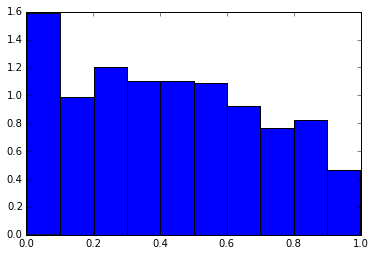

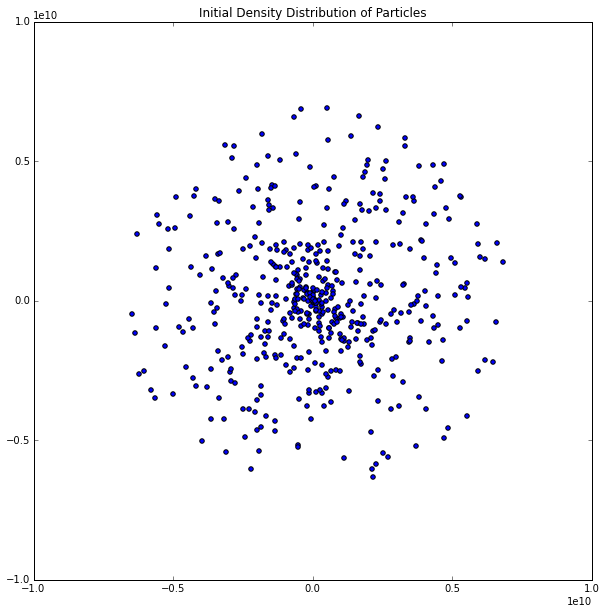

In [328]:
nParticles = 500
lower, upper = 0, 1
mu, sigma = 0, 0.8
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
plt.hist(X.rvs(nParticles), normed=True)

radiusDistribution = X.rvs(nParticles) * RJupiter
thetaDistribution = np.random.uniform(0, 2*np.pi, size=nParticles)

plt.figure(figsize=(10,10))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), \
            radiusDistribution*np.sin(thetaDistribution))
plt.title("Initial Density Distribution of Particles")
plt.xlim(-1e10,1e10)
plt.ylim(-1e10,1e10)

### Initialize Cartesian Position of Planets

In [329]:
def polar2cart(r, theta):
    return np.array([r*np.cos(theta), r*np.sin(theta)]).T

xyDistribution = polar2cart(radiusDistribution, thetaDistribution)
nParticles = len(xyDistribution)

### Density Update Function

In [330]:
def densityUpdate():
    
    global xyDistribution
    global rhoDistribution
    global mDistribution

    rhoDistribution = np.zeros_like(rhoDistribution)
    # "Self-density" contribution
    for i in range(0, nParticles):
#        rhoDistribution[i] = mDistribution[i]*W(0, h)
        
        # Density contribution from other particles
        for j in range(i, nParticles):
            xdist = (xyDistribution[i,0]-xyDistribution[j,0])
            ydist = (xyDistribution[i,1]-xyDistribution[j,1])
            dist_ij = np.sqrt(xdist**2 + ydist**2)
            rho_ij = mDistribution[i]*W(dist_ij, h)
            rhoDistribution[i] += rho_ij
            rhoDistribution[j] += rho_ij

### Smoothing function
Source 1: http://arxiv.org/pdf/1007.1245.pdf

Source 2: http://arxiv.org/pdf/1012.1885.pdf

\begin{equation}
\nabla W = \frac{3x(3r - 4h)}{4 \pi h^6}, \frac{3y(3r - 4h)}{4 \pi h^6} r< h
\end{equation}

\begin{equation}
\nabla W = -\frac{3x(-2h+r)^2}{4h^6 \pi r}, -\frac{3y(-2h+r)^2}{4h^6 \pi r} h < r< 2h
\end{equation}

In [331]:
def W(dist, h):
    '''
    Inputs:
        dist: a scalar distance between particles i an j
        h: smoothing length
    '''
    if dist < h:
        return 2/(np.pi*h**3) * \
               (1/4*(2-dist/h)**3 - (1-dist/h)**3)
    elif dist > 2 * h:
        return 0
    else:
        return 1/(np.pi*h**3) * (1/4*(2-dist/h)**3)

In [332]:
def gradW(xyDist, h):
    '''
    Inputs:
        xyDist: a [2,1] array containing the difference in [x,y] position
            between two particles
        h: smoothing length
    Outputs:
        a [2,1] array containing the [x,y] component of gradW
    '''
    
    dist = np.sqrt(xyDist[0]**2 + xyDist[1]**2)
    
    if dist < h:
        return np.array(
                [3*xyDist[0]*(3*dist - 4*h)/(4*np.pi*h**6),
                 3*xyDist[1]*(3*dist - 4*h)/(4*np.pi*h**6)])
    # 2D kernel
#         return np.array(
#               [15*xyDist[0]*(3*dist - 4*h)/(14 * np.pi * h**5),
#                15*xyDist[1]*(3*dist - 4*h)/(14 * np.pi * h**5)])
    
    elif dist > 2 * h:
        return np.array([0,0])
    
    else:
        return np.array(
                [-3*xyDist[0]*(-2*h+dist)**2/(4*h**6*np.pi*dist),
                 -3*xyDist[1]*(-2*h+dist)**2/(4*h**6*np.pi*dist)])
#         return np.array(
#                 [-15*xyDist[0]*(2*h - dist)**2/(14*h**5*np.pi*dist),
#                  -15*xyDist[1]*(2*h - dist)**2/(14*h**5*np.pi*dist)] )

In [333]:
### --- gradW test --- ###

# asd = np.linspace(1,1e10, 100)
# qwer = []
# for i in asd:
#     qwer.append(gradW([0,i], h))
    
# plt.plot(asd, qwer)

### Define Pressure Gradient

In [334]:
def gradP():
    
    gradPArray = np.zeros_like(velocityDistribution)

    for i in range(0, nParticles):
        for j in range(i, nParticles):
            
            xdist = (xyDistribution[i,0]-xyDistribution[j,0])
            ydist = (xyDistribution[i,1]-xyDistribution[j,1])
            distArr = np.array([xdist,ydist])
            
            #gradPX = mDistribution[j]/2*((pressureDistribution[i]/(rhoDistribution[i]**2))+(pressureDistribution[j]/(rhoDistribution[j]**2)))*gradW(distArr,h)[0]
            #gradPY = mDistribution[j]/2*((pressureDistribution[i]/(rhoDistribution[i]**2))+(pressureDistribution[j]/(rhoDistribution[j]**2)))*gradW(distArr,h)[1]
            gradPX = mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[0]
            gradPY = mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[1]
            
            gradPArray[i,0] += gradPX
            gradPArray[i,1] += gradPY
            gradPArray[j,0] += gradPX
            gradPArray[j,1] += gradPY

    return gradPArray

### Define gravity

In [335]:
def gravity(xyDistribution):
    
    global velocityDistribution
#    global xyDistribution
    global h
    
    deltaV = np.zeros_like(xyDistribution, dtype = np.float)
    for j in range(0, nParticles):
        for k in range(0, nParticles):
            if (k!=j):
                xdist = (xyDistribution[j,0]-xyDistribution[k,0])
                ydist = (xyDistribution[j,1]-xyDistribution[k,1])
#                print xyDistribution
#                print "xdist:", xdist
#                print(ydist)

                if(abs(xdist)<5e8):
#                    deltaV[j,0] -= -G*mDistribution[j]*xdist/((np.sqrt(xdist**2+ydist**2))**3)
                    deltaV[j,0] -= 0
#                    print "X less than smoothing"
                else:
                    deltaV[j,0] += -G*mDistribution[j]*xdist/((np.sqrt(xdist**2+ydist**2))**3)

                if(abs(ydist)<5e8):
#                    deltaV[j,1] -= -G*mDistribution[j]*ydist/((np.sqrt(xdist**2+ydist**2))**3)
                    deltaV[j,1] -= 0
#                    print "Y less than smoothing"
                else:
                    deltaV[j,1] += -G*mDistribution[j]*ydist/((np.sqrt(xdist**2+ydist**2))**3)
                    
    return deltaV

nb_gravity = nb.autojit(gravity)

### Model Initial Velocity & Density & Pressure Distribution

In [336]:
velocityDistribution = np.zeros_like(xyDistribution)
rhoDistribution = np.zeros_like(radiusDistribution)
mDistribution = np.ones(len(radiusDistribution))*mJupiter/len(radiusDistribution)
densityUpdate()
pressureDistribution = K * rhoDistribution ** gamma

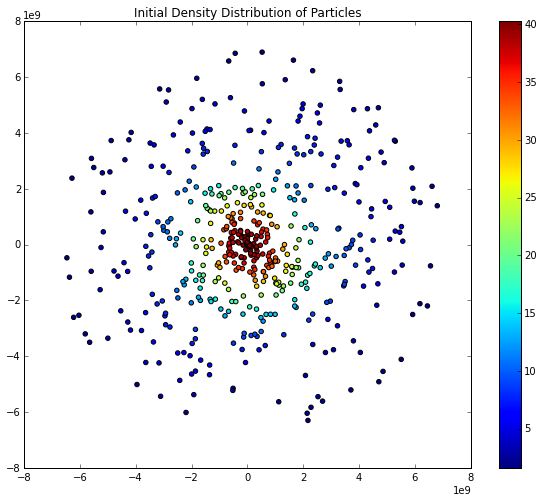

In [337]:
plt.figure(figsize=(10,8))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), \
            radiusDistribution*np.sin(thetaDistribution), c=rhoDistribution)
plt.title("Initial Density Distribution of Particles")
plt.colorbar()
plt.show()

### Run through RK1
* If just pressure, run at 1e2 timestep

In [338]:
# RK1 Parameters
t0 = time.time()
t = 0
dt = 1e2
stepN = 100

# Particle history
ParticlePositionHistory = np.zeros((stepN,nParticles,2))
ParticleRhoHistory = np.zeros((stepN, nParticles, 1))
xyDistributionOld = np.copy(xyDistribution)

# Force history
forceHistory = np.zeros((stepN, 3))
for i in range(stepN):
    if i % 10 == 0:
        print "Time step", i
    if i == 2:
        rhoOld = np.copy(rhoDistribution)
    deltaVf = np.zeros_like(xyDistribution, dtype = np.float)
    
    t += 1
    ParticlePositionHistory[i,:,:] = xyDistribution
    
    deltaVf += nb_gravity(xyDistribution) 
#    print "\nAvg gravity", np.mean(deltaVf)
    forceHistory[i,0] = np.mean(abs(deltaVf))
    
    deltaVf -= -gradP()/rhoDistribution[:,np.newaxis]
#    print "Avg gravity + pressure", np.mean(deltaVf)
    forceHistory[i,1] = np.mean(abs(deltaVf))

    deltaVf +=  -v*velocityDistribution**1
#    print "Avg damping:", np.mean(velocityDistribution)    
    forceHistory[i,2] = np.mean(-v*velocityDistribution**1)

    
    velocityDistribution += dt*deltaVf    
    xyDistribution += dt*velocityDistribution
    
    densityUpdate()
    ParticleRhoHistory[i,:,:] = rhoDistribution[:,np.newaxis]
    pressureDistribution = K*rhoDistribution**2

print(time.time()-t0)
#print(rhoDistribution-rhoOld)
#print(xyDistribution-xyDistributionOld) 


Time step 0
Time step 10
Time step 20
Time step 30
Time step 40
Time step 50
Time step 60
Time step 70
Time step 80
Time step 90
208.211999893


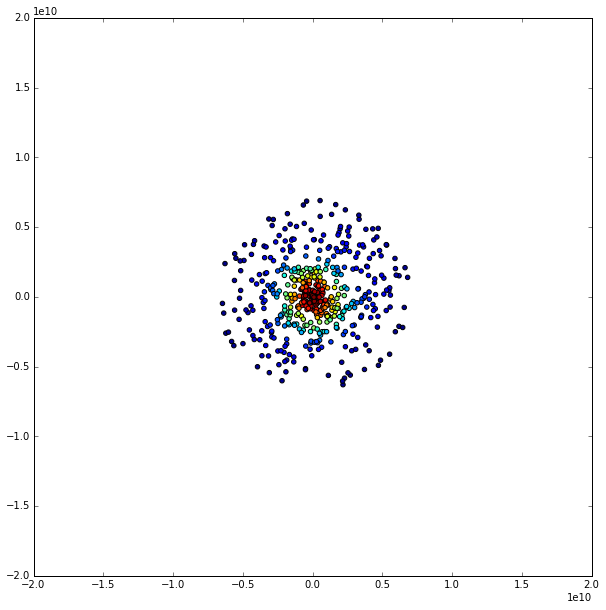

In [339]:
slider = FloatSlider(description='Time', min=1, max=stepN, step=1)

def update_plot():
    time=slider.value
    x = ParticlePositionHistory[time-1,:,0]
    y = ParticlePositionHistory[time-1,:,1]
    fig = plt.figure(figsize=(10,10))
    plt.scatter(x, y, c=ParticleRhoHistory[time-1,:,:])
    plt.xlim(-2e10, 2e10)
    plt.ylim(-2e10, 2e10)
#    plt.colorbar()

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()

[]

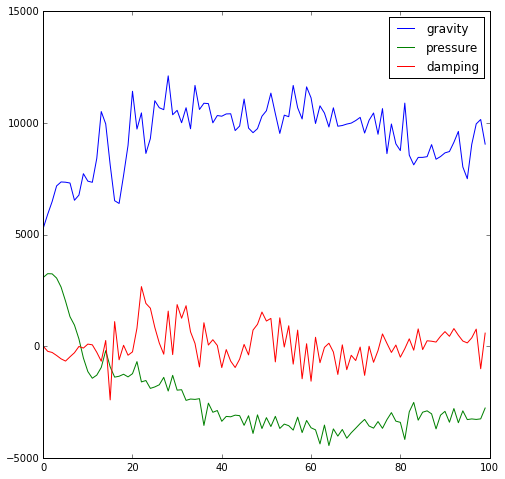

In [340]:
plt.figure(figsize=(8,8))
plt.plot(range(stepN), forceHistory[:,0], label='gravity')
plt.plot(range(stepN), forceHistory[:,1] - forceHistory[:,0], label='pressure')
plt.plot(range(stepN), forceHistory[:,2], label='damping')
#plt.plot(range(stepN), forceHistory[:,1] + forceHistory[:,2], label='net')
#plt.plot(range(stepN), forceHistory[:,1] + forceHistory[:,2], label='net')
plt.legend()
plt.plot()